In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(binom)

devtools::load_all(".")

plan(multiprocess)

options(future.globals.maxSize = 1500*1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/archaic-ychr
Loading required package: future
Loading ychr


In [7]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

In [41]:
times_df <- filter(
    tmrca_df,
    afr == "a00", 
    (arch == "mez2" & capture == "full") | (arch == "elsidron2" & capture == "lippold"),
    sites == "all",
    dp == 3,
    filt == "filt50"
) %>%
group_by(arch) %>%
summarise(tmrca = mean(tmrca_new)) %>%
mutate(age = c(44000, 49000))

times_df

arch,tmrca,age
<chr>,<dbl>,<dbl>
elsidron2,366586.4,44000
mez2,377946.1,49000


In [62]:
#' Get positions at which individual 'ind' is different from
#' a set of individuals in 'group' (including hg19) and merge
#' those genotypes with 'test' individual at those positions
#' - this is the individual for whom we want to calculate TMRCA
#' with ind.
get_differences <- function(test, ind, polarize_by, gt, mindp) {
    capture <- ifelse(str_detect(test, "elsidron2"), "lippold", "full")

    ## load genotypes of the test individual
    test_gt <- here(paste0("data/vcf/", capture, "_", test, ".vcf.gz")) %>%
        read_vcf(mindp = mindp, maxdp = 0.98) %>%
        filter(!is.na(!!sym(test))) # keep only sites with data

    ## subset all high-coverage genotypes to samples of interest
    gt <- gt[, c("chrom", "pos", "REF", "ALT", ind, polarize_by)]
    ## keep fixed differences between a group of individuals
    ## and sample 'ind' (implicitly includes hg19 to 'polarize_by')
    freq <- gt[, polarize_by] %>% rowMeans
    differences <- filter(gt, !!sym(ind) == 1, freq == 0)

    ## join genotypes of the test individual at informative sites
    joined_gt <- inner_join(differences, test_gt, by = c("chrom", "pos", "REF")) %>%
        filter(complete.cases(.)) %>%
        select(-ALT.y) %>%
        rename(ALT = ALT.x)

    joined_gt
}

In [79]:
estimate_split <- function(test, from, gt, ancestral_ind,  mindp) {
  derived <- get_differences(test, from, ancestral_ind, gt, mindp)

  counts <- ifelse(derived[[test]] == 0, "ref", "alt") %>%
    factor(levels = c("ref", "alt")) %>%
    table %>%
    as.matrix %>%
    t %>%
    as.data.frame

  times <- filter(times_df, arch == from)

  ## simulate confidence intervals by sampling REF/ALT counts from Poisson
  sample_refs <- rpois(1000, counts$ref)
  sample_alts <- rpois(1000, counts$alt)
  tmrca_ci <- quantile(
    sample_refs / (sample_refs + sample_alts) * (times$tmrca - times$age) + times$age,
    c(0.025, 0.975)
  )

  counts %>%
    mutate(
      name = test,
      prop_ref = ref / (ref + alt),
      tmrca = prop_ref * (times$tmrca - times$age) + times$age,
      tmrca_low = tmrca_ci[1],
      tmrca_high = tmrca_ci[2],
      dp = mindp
    ) %>%
    select(name, everything())
}

## Neandertal lineage defined by _Mezmaiskaya 2_

In [2]:
all_mez2 %<-% read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, nodmg = F, var_only = T)
nodmg_mez2 %<-% read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, nodmg = T, var_only = T)

In [3]:
nrow(all_mez2)
nrow(nodmg_mez2)

[1] 220488

[1] 155326

In [80]:
targets <- c("spy1", "elsidron2", "shotgun_spy1", "spy1_merged", "shotgun_mez2", paste0("elsidron2_dp", 1:7))
ancestral_ind <- c("a00", "chimp", "S_French_1")

All SNPs:

In [81]:
tmrca_mez2_all <- map_dfr(1:3, function(dp) {
    future_map_dfr(targets, ~ estimate_split(.x, "mez2", all_mez2, ancestral_ind, mindp = dp))
})

Non C-T/G-A SNPs:

In [85]:
tmrca_mez2_nodmg <- map_dfr(1:3, function(dp) {
    future_map_dfr(targets, ~ estimate_split(.x, "mez2", nodmg_mez2, ancestral_ind, mindp = dp))
})

In [103]:
tmrca_mez2 <- bind_rows(
    tmrca_mez2_all %>% mutate(sites = "all"),
    tmrca_mez2_nodmg %>% mutate(sites = "nodmg")
) %>% mutate(name = fix_name(name) %>% str_replace("^Spy 94a$", "Spy 94a (capture)"))

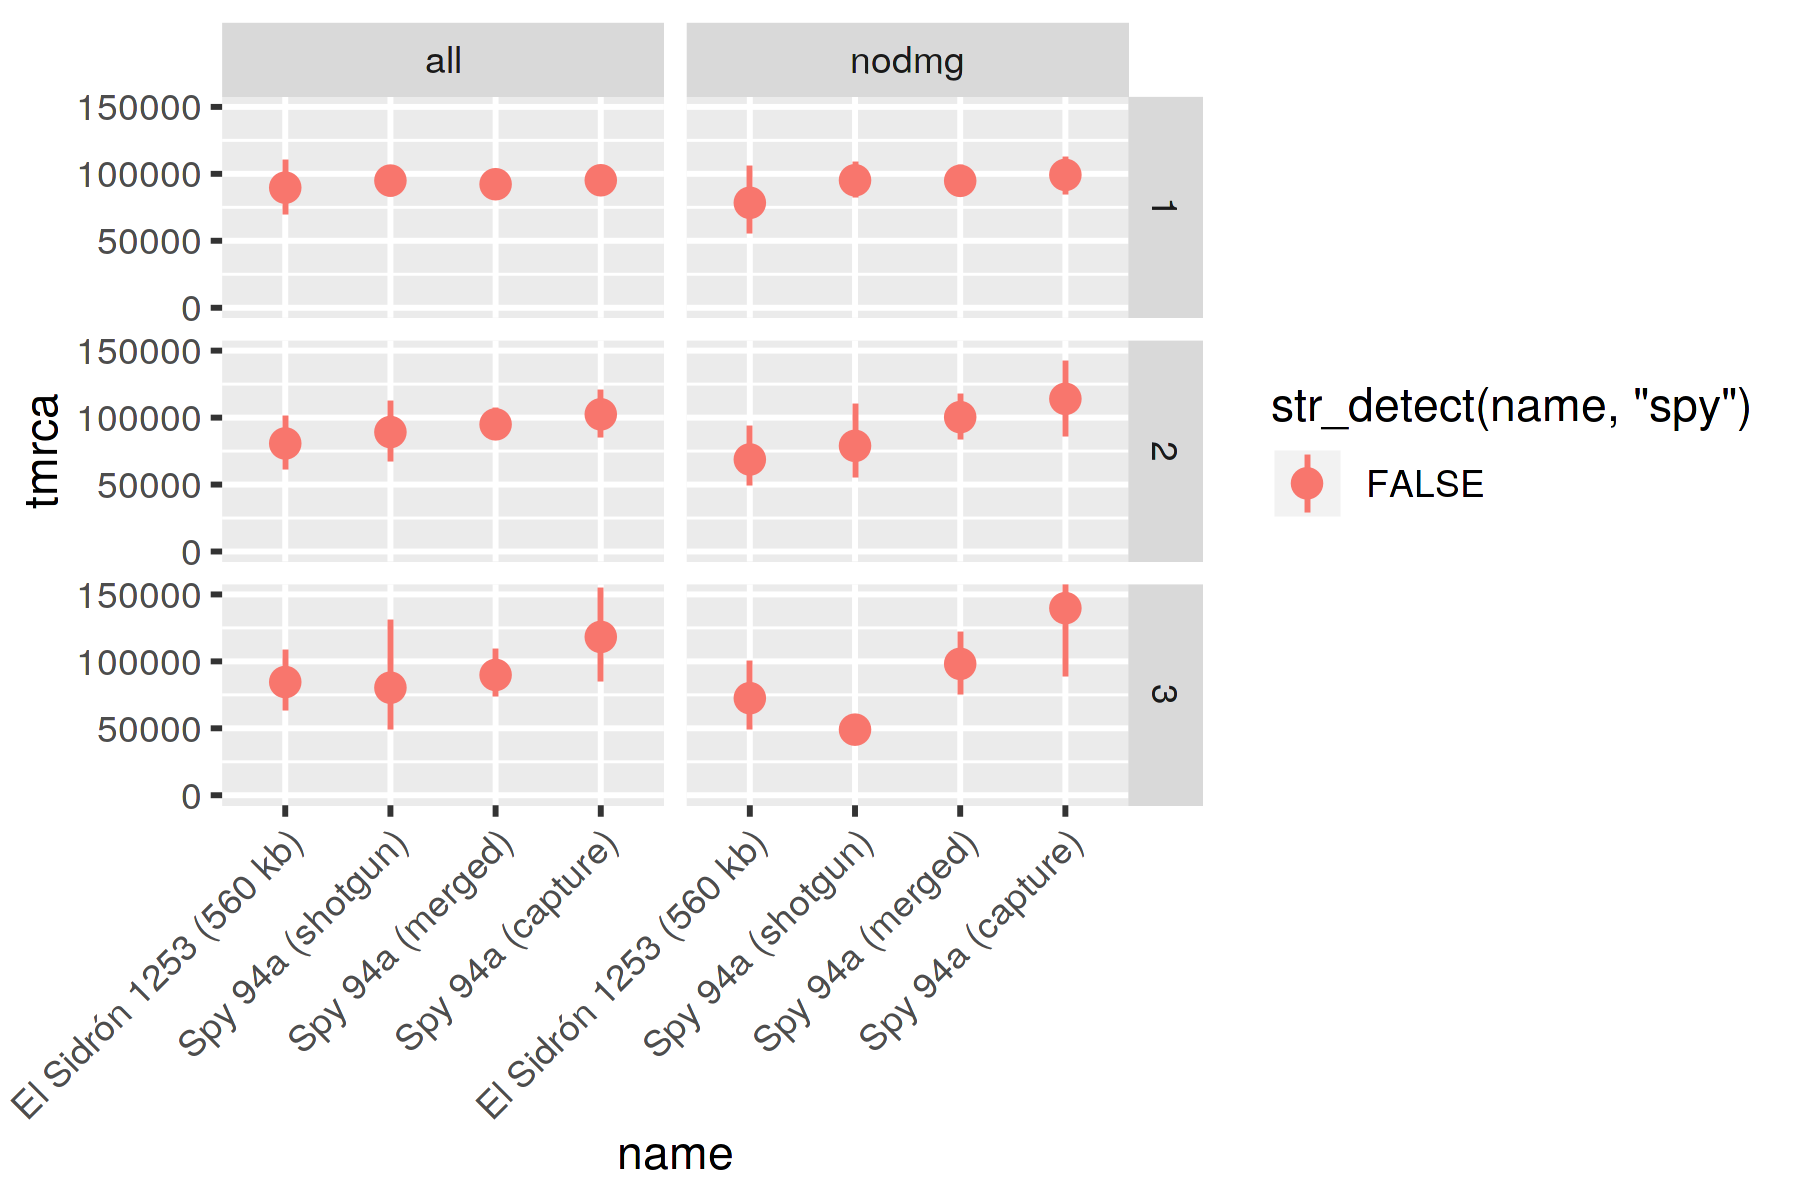

In [104]:
set_dim(6, 4)

tmrca_mez2 %>%
filter(!str_detect(name, "dp|Mezmaiskaya")) %>%
ggplot(aes(name, tmrca)) +
    geom_pointrange(aes(fct_reorder(name, tmrca), tmrca, ymin = tmrca_low, ymax = tmrca_high,
                        color = str_detect(name, "spy"))) +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    coord_cartesian(ylim = c(0, 150000)) +
    facet_grid(dp ~ sites)

In [ ]:
our_study_nodmg <- map_dfr(1:5, function(dp)
  future_map_dfr(c("spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2", paste0("elsidron2_dp", 1:7)),
                 ~ estimate_split(.x, "mez2", highcov_nodmg, c("a00", "chimp", "S_French_1"), mindp = dp) %>% mutate(mindp = dp))

In [70]:
our_study_nodmg1 <- future_map_dfr(c("spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2", paste0("elsidron2_dp", 1:7)),
                                  ~ estimate_split(.x, "mez2", highcov_nodmg, c("a00", "chimp", "S_French_1"), mindp = 1))

In [92]:
our_study_nodmg1 %>% arrange(-tmrca)

name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
spy1,40,222,0.152671756,94984.14,80797.07,110789.22
shotgun_spy1,34,208,0.140495868,90918.05,76221.99,105589.45
elsidron2_dp7,5,50,0.090909091,74358.74,50815.23,101582.45
elsidron2,5,51,0.089285714,73816.61,50300.87,104717.47
elsidron2_dp2,3,35,0.078947368,70364.16,44000.00,99691.62
elsidron2_dp4,4,49,0.075471698,69203.48,49757.69,94406.96
elsidron2_dp1,2,25,0.074074074,68736.75,44000.00,108230.76
elsidron2_dp5,4,50,0.074074074,68736.75,49757.69,95952.97
elsidron2_dp6,4,50,0.074074074,68736.75,48977.25,94940.93


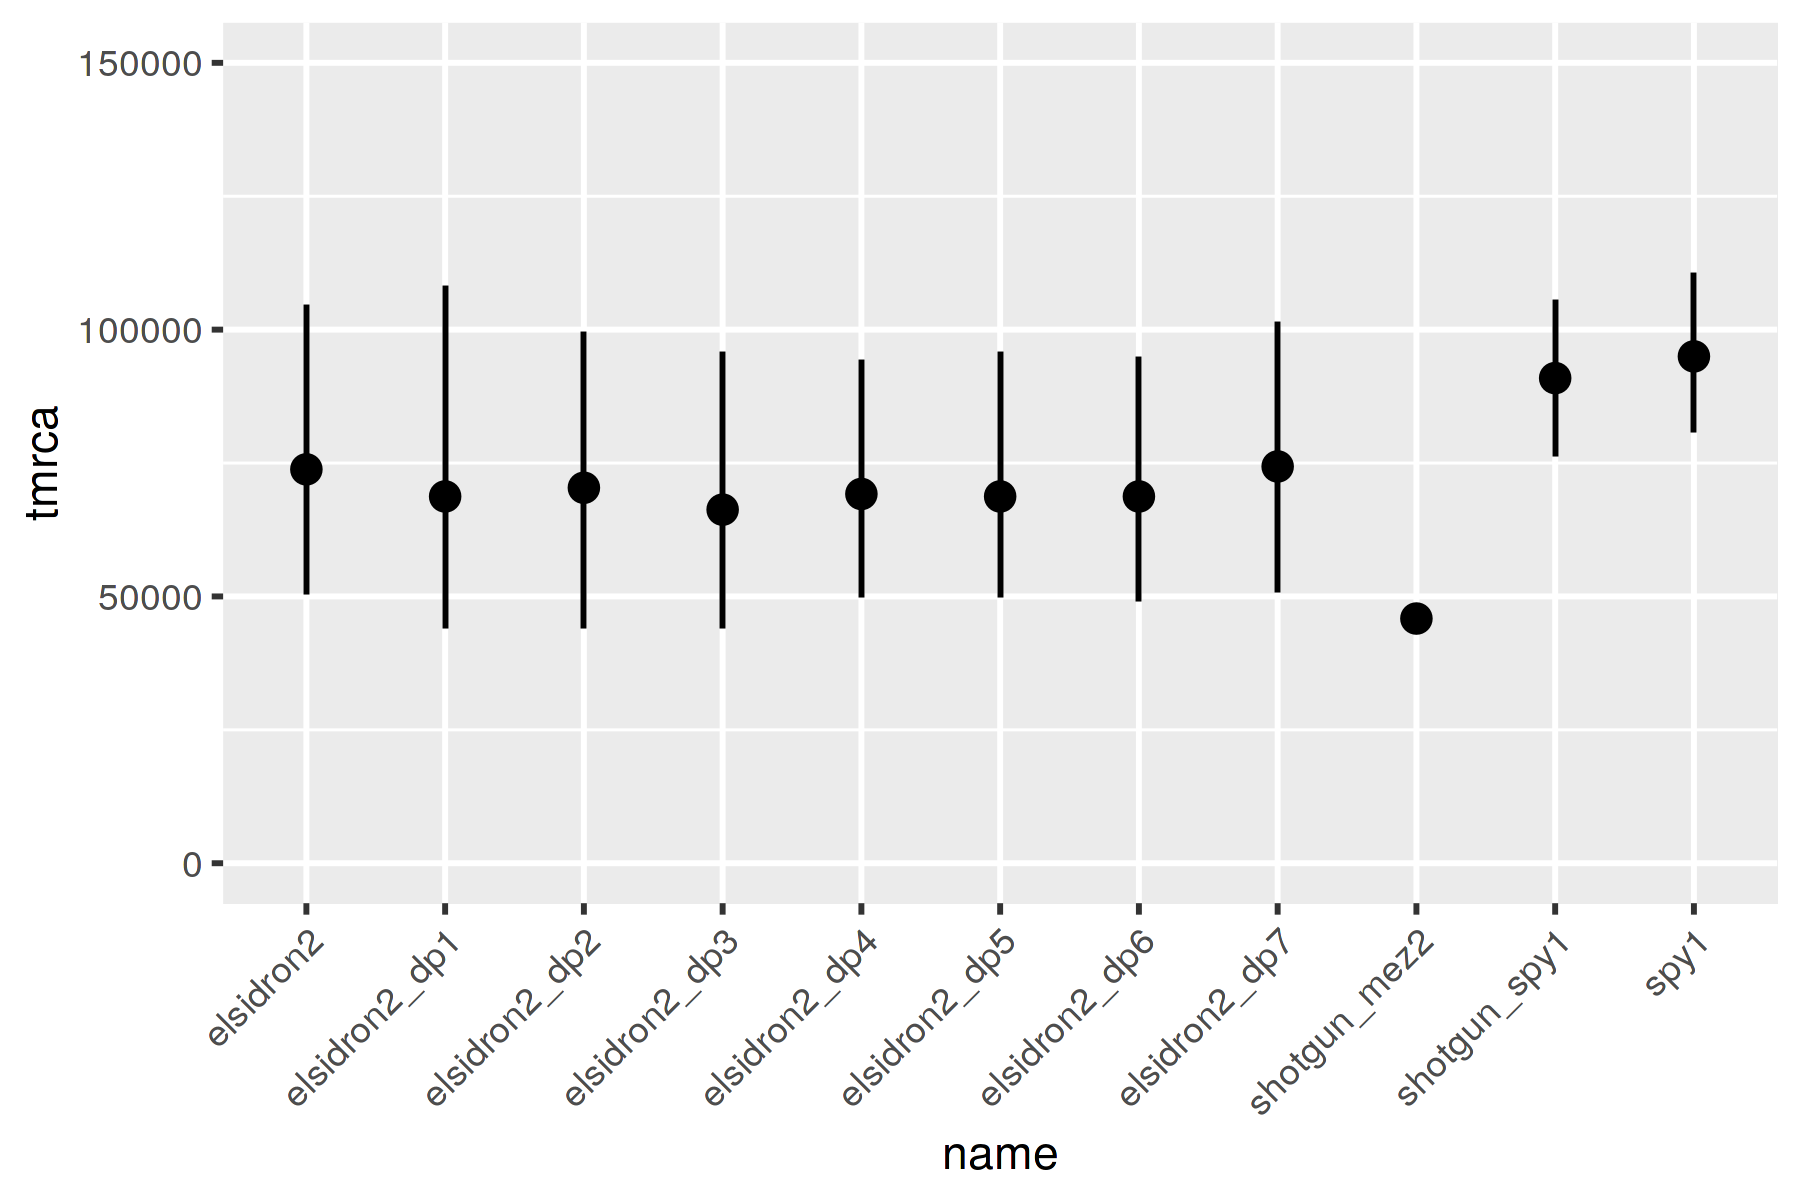

In [93]:
set_dim(6, 4)
ggplot(our_study_nodmg1, aes(name, tmrca)) +
  geom_pointrange(aes(name, tmrca, ymin = tmrca_low, ymax = tmrca_high)) +
  theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
  coord_cartesian(ylim = c(0, 150000))

# Test Mez2 divergence based on El Sidron-defined informative sites

In [41]:
lippold_all %<-% read_genotypes("elsidron2", "lippold", mindp = 3, maxdp = 0.98, nodmg = F, var_only = T)
lippold_nodmg %<-% read_genotypes("elsidron2", "lippold", mindp = 3, maxdp = 0.98, nodmg = T, var_only = T)

In [46]:
estimate_split("mez2", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 3)

name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2,18,61,0.2278481,120089,91089.33,150867


In [47]:
estimate_split("mez2", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)

name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2,18,61,0.2278481,120089,92751.84,155315.4


In [48]:
estimate_split("mez2_dp1", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)

name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp1,13,38,0.254902,129123.5,91706.58,167414.9


In [52]:
estimate_split("mez2_dp1", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)
estimate_split("mez2_dp2", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)
estimate_split("mez2_dp3", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)
estimate_split("mez2_dp4", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)
estimate_split("mez2_dp5", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)

name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp1,13,38,0.254902,129123.5,91706.58,173036.2


name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp2,15,51,0.2272727,119896.8,87362.63,153764.9


name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp3,18,57,0.24,124147.1,92692.91,155347.7


name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp4,17,59,0.2236842,118698.5,88526.14,150266.1


name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp5,16,59,0.2133333,115241.8,85743.26,146039.1


In [53]:
estimate_split("mez2_dp6", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)
estimate_split("mez2_dp7", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)
estimate_split("mez2_dp8", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)
estimate_split("mez2_dp9", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)
estimate_split("mez2_dp10", "elsidron2", lippold_all, c("a00", "chimp", "S_French_1"), mindp = 1)

name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp6,16,62,0.2051282,112501.8,85212.59,142224.6


name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp7,18,63,0.2222222,118210.2,88784.15,151192.6


name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp8,17,61,0.2179487,116783.1,87553.47,149215.9


name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp9,17,62,0.2151899,115861.8,87722,145641.9


name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp10,19,66,0.2235294,118646.8,89216.98,149061.7
